In [1]:
# Imports
import numpy as np
import csv
import sklearn
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

# Predict via the user-specific median.
# If the user has no data, use the global median.

# Hard-code file names
train_file = 'data/LoanStats_2016Q1.csv' # 2016 Q1
train_file = 'data/LoanStats3a.csv' # 2007-2011
train_file = 'data/LoanStats3b.csv' # 2012-2013
train_file = 'data/LoanStats3c.csv' # 2014
# train_file = 'data/LoanStats3d.csv' # 2015

In [2]:
df = pd.read_csv(train_file, skiprows=1)
print df.shape

(235631, 111)


/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# FILTER OUT LOANS THAT ARE STILL CURRENT...
df = df[df['loan_status'] != 'Current']

feature_set = ['loan_amnt', 'installment', 'annual_inc', 'int_rate', 'dti', 'delinq_2yrs', 'revol_util']
features = df[feature_set]

def clean_percent(val):
    try:
        return float(val[:-1])
    except:
        return 0

def normalize_column(category, df, inplace=False):
    mean = np.nanmean(df[category])
    col_max = np.max(df[category])
    col_min = np.min(df[category])
    normed = df[category].apply(lambda x: x if pd.isnull(x) else (x - mean)/(col_max-col_min))

    if inplace:
        df[category] = normed
    else:
        return normed

    
features['int_rate'] = features['int_rate'].apply(clean_percent)
features['revol_util'] = features['revol_util'].apply(clean_percent)

for feature in feature_set:
    normalize_column(feature, features, True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

In [4]:
total_return = (df['total_pymnt'] + df['recoveries'] - df['collection_recovery_fee'])/df['loan_amnt']

# Add cleaned_results back to features data frame
features['total_return'] = total_return

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
df['loan_status'].value_counts()

Fully Paid            73905
Charged Off           21266
Late (31-120 days)     3940
In Grace Period        2522
Late (16-30 days)       817
Default                  66
Name: loan_status, dtype: int64

In [6]:
# count number of null rows
print np.sum(pd.isnull(features))
features = features.dropna(axis=0)

loan_amnt       2
installment     2
annual_inc      2
int_rate        0
dti             2
delinq_2yrs     2
revol_util      0
total_return    2
dtype: int64


In [7]:
X = features.drop(['total_return'], axis=1)
y = features[['total_return']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=37)

In [8]:
ridge_regressor = Ridge()
ridge_regressor.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [9]:
rf_regressor = RandomForestRegressor(n_estimators=150, min_samples_split=10, max_depth=10)
rf_regressor.fit(X_train, y_train)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

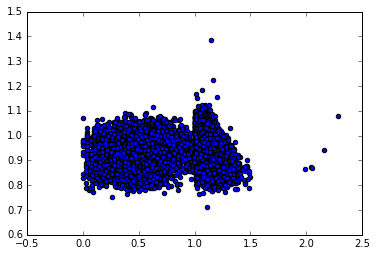

Testing error - Ridge Score was: 1712.717780


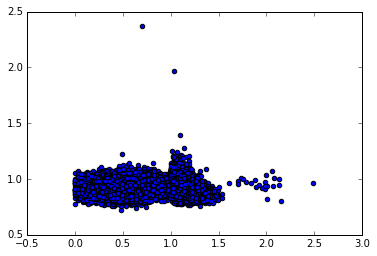

Training error - Ridge Score was: 6801.935610


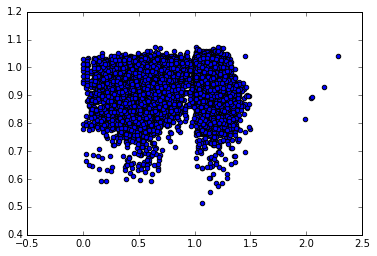

Testing error - RandomForest Score was: 1696.492529


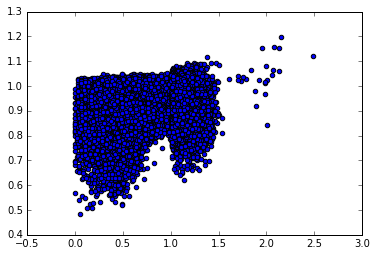

Training error - RandomForest Score was: 6134.272336


In [10]:
def score(regressor, X, y):
    predicted_y = regressor.predict(X)
    plt.scatter(y, predicted_y)
    plt.show()
    return np.sum(np.square(y - np.reshape(predicted_y, (len(predicted_y),1))))

# print regressor.predict(X_test)

print "Testing error - Ridge Score was: %f" % (score(ridge_regressor, X_test, y_test))
print "Training error - Ridge Score was: %f" % (score(ridge_regressor, X_train, y_train))

print "Testing error - RandomForest Score was: %f" % (score(rf_regressor, X_test, y_test))
print "Training error - RandomForest Score was: %f" % (score(rf_regressor, X_train, y_train))

In [11]:
# SNIPPET TO BROWSE LOANS VIA LENDING CLUB API
# NB: JSON KEYS DO NOT MATCH WITH CSV DATA...

import json
import pprint
import requests

pp = pprint.PrettyPrinter(indent=4)
s = requests.Session()
s.headers.update({'Authorization':'ZRYl2TYNY6v0yL/Cozf7B9US+uc='})
r = s.get('https://api.lendingclub.com/api/investor/v1/loans/listing')
# pp.pprint(json.loads(r.text))

Some thoughts...
- We should be able to take in the entire feed of loans and rank loans by a "quality metric"
- What is quality? Perhaps it should be a mismatch on the interest rate? The problem with this is that the IR is assigned by LendingClub
- Perhaps, it should be the overall return for a given loan (e.g. Interest Pymnts + Principal Pymnts + Late Fees + Recoveries - Recovery Collection Fee)

Feature Engineering...
- Installment / Income
- DTI